# Inference with Segment-Enformer

[![Open All Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/instadeepai/nucleotide-transformer/blob/main/notebooks/segment_nt/inference_segment_enformer.ipynb)

## Installation and imports

In [ ]:
!pip install boto3
!pip install matplotlib
!pip install biopython
!pip install dm-haiku

In [2]:
import os

try:
    import nucleotide_transformer
except:
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()

In [3]:
from Bio import SeqIO
import gzip
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt
from nucleotide_transformer.enformer.pretrained import get_pretrained_segment_enformer_model
from nucleotide_transformer.enformer.features import FEATURES

jax.config.update("jax_platform_name", "cpu")

backend = "cpu"
devices = jax.devices(backend)
num_devices = len(devices)
print(f"Devices found: {devices}")

Devices found: [CpuDevice(id=0)]


# Define function that plots the probabilities

In [4]:
# seaborn settings
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1,
    rc={
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        }
)

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# set colors
colors = sns.color_palette("Set2").as_hex()
colors2 = sns.color_palette("husl").as_hex()

# Rearrange order of the features to match Fig.3 from the paper.
features_rearranged = [
 'protein_coding_gene',
 'lncRNA',
 '5UTR',
 '3UTR',
 'exon',
 'intron',
 'splice_donor',
 'splice_acceptor',
 'promoter_Tissue_specific',
 'promoter_Tissue_invariant',
 'enhancer_Tissue_specific',
 'enhancer_Tissue_invariant',
 'CTCF-bound',
 'polyA_signal',
]

def plot_features(
    predicted_probabilities_all,
    seq_length: int,
    features: List[str],
    order_to_plot: List[str],
    fig_width=8,
):
    """
    Function to plot labels and predicted probabilities.

    Args:
        predicted_probabilities_all: Probabilities per genomic feature for each
            nucleotides in the DNA sequence.
        seq_length: DNA sequence length.
        feature: Genomic features to plot.
        order_to_plot: Order in which to plot the genomic features. This needs to be
            specified in order to match the order presented in the Fig.3 of the paper
        fig_width: Width of the figure
    """

    sc = 1.8
    n_panels = 7

    # fig, axes = plt.subplots(n_panels, 1, figsize=(fig_width * sc, (n_panels + 2) * sc), height_ratios=[6] + [2] * (n_panels-1))
    _, axes = plt.subplots(n_panels, 1, figsize=(fig_width * sc, (n_panels + 4) * sc))

    for n, feat in enumerate(order_to_plot):
        feat_id = features.index(feat)
        prob_dist = predicted_probabilities_all[:, feat_id]

        # Use the appropriate subplot
        ax = axes[n // 2]

        try:
            id_color = colors[feat_id]
        except:
            id_color = colors2[feat_id - 8]
        ax.plot(
            prob_dist,
            color=id_color,
            label=feat,
            linestyle="-",
            linewidth=1.5,
        )
        ax.set_xlim(0, seq_length)
        ax.grid(False)
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')

    for a in range (0,n_panels):
        axes[a].set_ylim(0, 1.05)
        axes[a].set_ylabel("Prob.")
        axes[a].legend(loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0)
        if a != (n_panels-1):
            axes[a].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)

    # Set common x-axis label
    axes[-1].set_xlabel("Nucleotides")
    # axes[0].axis('off')  # Turn off the axis
    axes[n_panels-1].grid(False)
    axes[n_panels-1].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False)

    axes[0].set_title("Probabilities predicted over all genomics features", fontweight="bold")

    plt.show()


# Get human chromosome 20

To reproduce the figures of the Segment-NT paper, we retrieve here the file of the
human chromosome 20

### Download fasta file of chromosome 20 of the human genome

In [ ]:
!wget https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz

In [6]:
fasta_path = "Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz"

with gzip.open(fasta_path, "rt") as handle:
    record = next(SeqIO.parse(handle, "fasta"))
    chr20 = str(record.seq)

# Infer on 196608bp genomic sequence

## Instantiate SegmentEnformer inference function
The following cells allow you to download the weights of SegmentEnformer. It returns the weights dictionary, the haiku forward function, the tokenizer and the config dictionary.

In [7]:
parameters, state, forward_fn, tokenizer, config = get_pretrained_segment_enformer_model()

In [8]:
forward_fn = hk.transform_with_state(forward_fn)
apply_fn = jax.pmap(forward_fn.apply, devices=devices, donate_argnums=(0,))

# Put required quantities for the inference on the devices. This step is not
# reproduced in the second inference since the quantities will already be loaded
# on the devices !
random_key = jax.random.PRNGKey(seed=0)
keys = jax.device_put_replicated(random_key, devices=devices)
parameters = jax.device_put_replicated(parameters, devices=devices)
state = jax.device_put_replicated(state, devices=devices)

## Tokenize the DNA sequence

In [9]:
num_nucleotides = 196_608
idx_start = 2650520

idx_stop = idx_start + num_nucleotides

sequences = [chr20[idx_start:idx_stop]]
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]

# This stacks the batch so that it is repeated across the devices. This is done
# in order to allow for replication even if one has more than one device.
# To take advantage of the multiple devices and infer different sequences on
# each of the devices, make sure to change this line into a reshape.
# a reshape
tokens = jnp.stack([jnp.asarray(tokens_ids, dtype=jnp.int32)]*num_devices, axis=0)
tokens.shape


(1, 1, 196608)

## Infer on the resulting batch

In [ ]:
# Infer
outs, state = apply_fn(parameters, state, keys, tokens) 

# Obtain the logits over the genomic features
logits = outs["logits"]
# Transform them on probabilities
probabilities = np.asarray(jax.nn.softmax(logits, axis=-1))[...,-1]

In [11]:
probabilities.shape

(1, 1, 196608, 14)

## Plot the probabilities for 14 genomic features along this DNA sequence

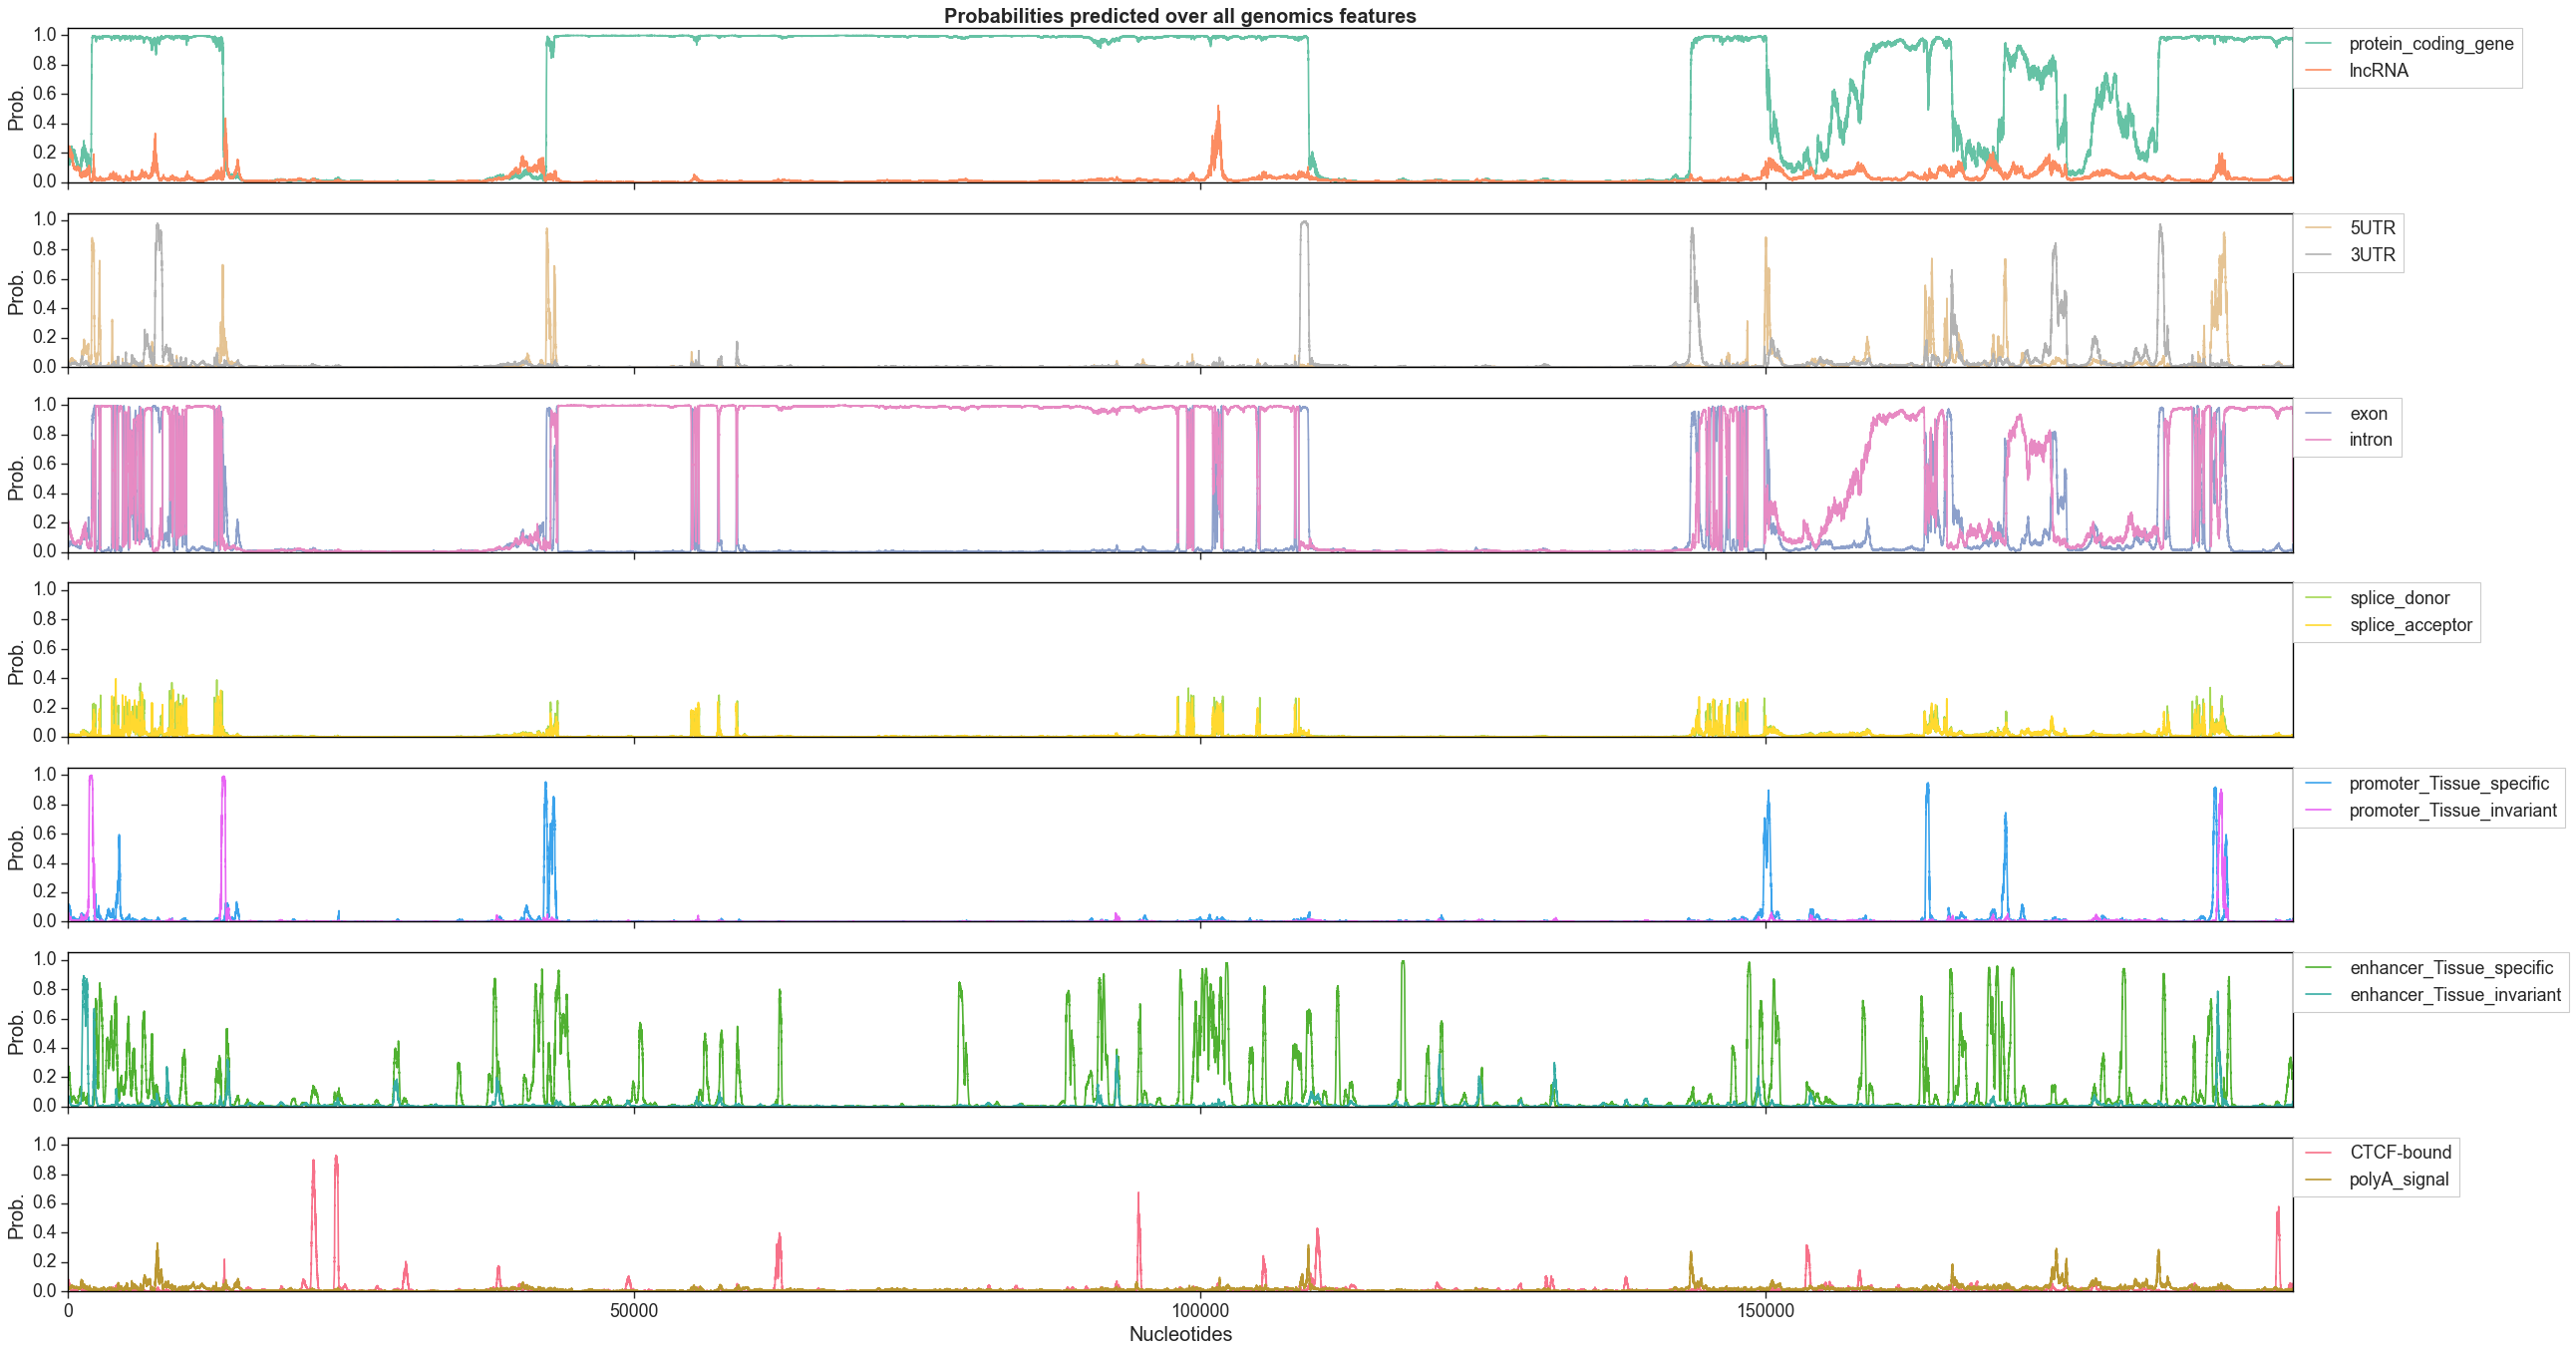

In [12]:
plot_features(
    probabilities[0, 0],
    probabilities.shape[-2],
    fig_width=20,
    features=FEATURES,
    order_to_plot=features_rearranged
)